<a href="https://colab.research.google.com/github/denizmsayin/singan/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.__version__

'1.5.0+cu101'

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [0]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xvzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [0]:
class Conv2DBlock(nn.Module):
  """ Combine Conv2d-BN-LReLU into a single block """
  # the 0.2 negative slope is given in the supplementary materials
  def __init__(self, in_channels, out_channels, kernel_size, use_bn=True, activation=None, conv_kwargs={}, bn_kwargs={}, conv_initializer=None, bn_initializer=None):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **conv_kwargs)
    self.bn = nn.BatchNorm2d(out_channels, **bn_kwargs) if use_bn else nn.Identity()
    self.activ = activation if activation else nn.Identity()
    # original authors use custom initialization
    if conv_initializer:
      conv_initializer(self.conv)
    if use_bn and bn_initializer:
      bn_initializer(self.bn)
  
  def forward(self, x):
    return self.activ(self.bn(self.conv(x)))

class SGNet(nn.Module):
  def __init__(self, output_channels=3, kernel_count=32, final_activation=nn.Tanh(), final_bn=False, conv_init=None, bn_init=None, num_blocks=5):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.ZeroPad2d(num_blocks)) # initial padding, as explained in the SM
    in_channels = 3
    for _ in range(num_blocks-1): # multiple Conv2D blocks with LeakyReLU
      self.layers.append(Conv2DBlock(in_channels, kernel_count, 3, nn.LeakyReLU(negative_slope=0.2), conv_initializer=conv_init, bn_initializer=bn_init))
      in_channels = kernel_count
    # the final activation depends on whether this is the generator or critic
    self.layers.append(Conv2DBlock(kernel_count, output_channels, 3, final_bn, final_activation, conv_initializer=conv_init, bn_initializer=bn_init))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

# [gen1] -> View, crit1 = View + crit1
# [gen1, gen2] -> View, crit2 = View + crit2
# ...

def sample_noise_like(ref_img, mean=0.0, stdev=1.0, device='cpu'):
  return torch.from_numpy(np.random.normal(loc=mean, scale=stdev, size=ref_img.shape)).type(ref_img.dtype).to(device)

class MultiScaleSGNetView(nn.Module):
  def __init__(self, scales, scale_sizes, noise_sampler):
    super().__init__()
    # scales = ModuleList[gen1, gen2 ...]
    self.scales = scales
    self.noise_sampler = noise_sampler
    self.scale_sizes = scale_sizes # e.g. [(30, 40), (60, 80), (120, 160)]
    for g in self.scales[:-1]:
      g.requires_grad_(False)
      g.eval()

  def forward(self, x, z_input=None):
    """
    z_input: either None (noise is generated automatically), 
             a single tensor (used as input to the coarsest scale)
             or a list of tensors (used as input to each scale in asc. order)
    """
    for i, g, in enumerate(self.scales):
      if z_input is None:
        z = self.noise_sampler(x)
      elif type(z_input) is list:
        z = z_input[i]
      else:
        z, z_input = z_input, None
      g_input = x + z # add the noise and input image
      x_gen = g(g_input) + x # add the gen. output and the input image
      if i < len(self.scales) - 1:
        x = F.interpolate(x_gen, size=self.scale_sizes[i+1], mode='bicubic')
    return x_gen

def get_weights_and_biases(model):
  return [t for k, t in model.state_dict().items() if 'weight' in k or 'bias' in k]
  

In [0]:
# as given in the paper
LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
LR_DROP_STEP = 1600
LR_DROP_MULT = 0.1
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1 # paper: 0.1
NUM_SCALES = 1
SCALING_FACTOR = 4/3
INITIAL_KERNEL_COUNT = 32
INCREASE_KERNEL_COUNT_EVERY = 4 # SCALES
NOISE_BASE_STD = 0.1
FIRST_SCALE_NOISE_STD = 1.0
START_SIZE = (25, 25)

def conv2d_initializer(conv2d):
  torch.nn.init.normal_(conv2d.weight, 0.0, 0.02)
  torch.nn.init.constant_(conv2d.bias, 0.0)

def batch_norm_initializer(bn):
  torch.nn.init.normal_(bn.weight, 1.0, 0.02)
  torch.nn.init.constant_(bn.bias, 0.0)


PRINT_EVERY = 25
DEVICE = 'cuda'
SEED = 796

Dataset already downloaded
BSDS300/images/train/109034.jpg


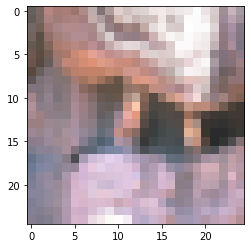

In [12]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize(START_SIZE, Image.BICUBIC))
plt.imshow(orig_img_uint)
print(EXAMPLE_IMG_PATH)

****************************
Scale 0
RMSE: 1.00
Norm sums:
Gen-0 norm: 29.56
Critic norm: 29.31
torch.Size([1, 3, 25, 25])
Step: 0
Generator adv: 0.005, rec: 0.196
Critic fake: -0.005 real: 0.178 grad: 0.128


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


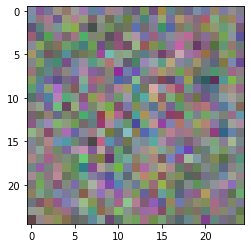

Step: 25
Generator adv: -0.214, rec: 0.086
Critic fake: 0.005 real: 0.514 grad: 1.245
Steps per second: 14.89


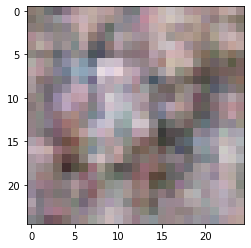

Step: 50
Generator adv: -0.198, rec: 0.081
Critic fake: 0.012 real: 0.573 grad: 1.413
Steps per second: 15.21


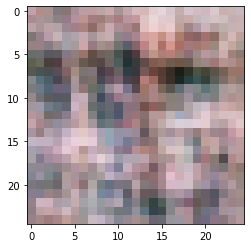

Step: 75
Generator adv: -0.061, rec: 0.076
Critic fake: 0.058 real: 0.707 grad: 2.343
Steps per second: 15.23


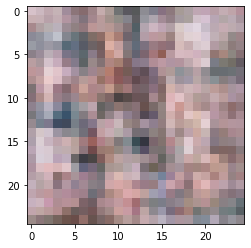

Step: 100
Generator adv: 0.222, rec: 0.075
Critic fake: 0.095 real: 0.761 grad: 2.924
Steps per second: 14.45


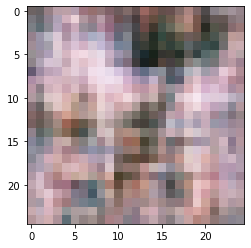

Step: 125
Generator adv: -0.118, rec: 0.075
Critic fake: 0.080 real: 0.870 grad: 1.095
Steps per second: 15.26


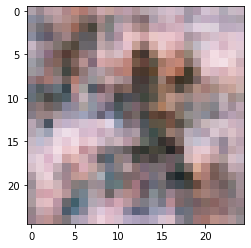

Step: 150
Generator adv: 0.062, rec: 0.075
Critic fake: 0.021 real: 0.774 grad: 3.523
Steps per second: 14.94


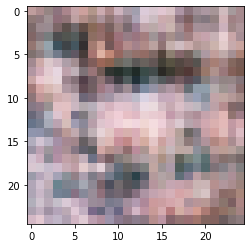

Step: 175
Generator adv: -0.057, rec: 0.072
Critic fake: -0.061 real: 0.828 grad: 1.371
Steps per second: 14.77


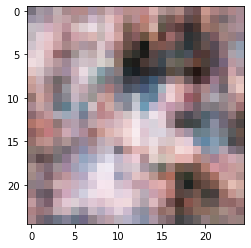

Step: 200
Generator adv: 0.134, rec: 0.073
Critic fake: 0.176 real: 0.807 grad: 2.923
Steps per second: 14.94


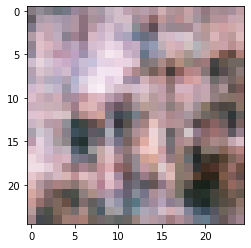

Step: 225
Generator adv: -0.006, rec: 0.074
Critic fake: -0.123 real: 0.881 grad: 2.277
Steps per second: 14.83


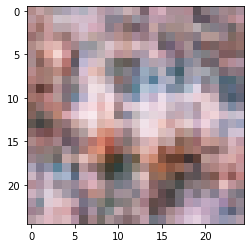

Step: 250
Generator adv: 0.079, rec: 0.073
Critic fake: 0.125 real: 0.865 grad: 1.701
Steps per second: 14.95


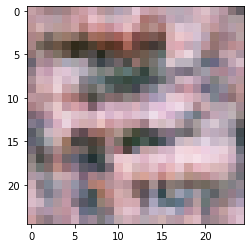

Step: 275
Generator adv: 0.148, rec: 0.070
Critic fake: 0.201 real: 0.879 grad: 1.881
Steps per second: 14.79


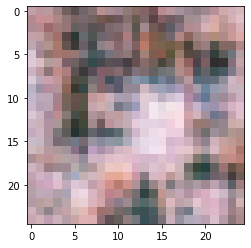

Step: 300
Generator adv: -0.144, rec: 0.073
Critic fake: 0.017 real: 0.825 grad: 1.439
Steps per second: 14.85


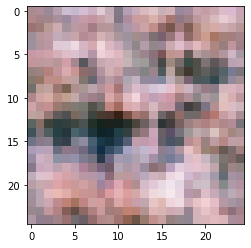

Step: 325
Generator adv: -0.001, rec: 0.075
Critic fake: -0.070 real: 0.824 grad: 1.452
Steps per second: 14.88


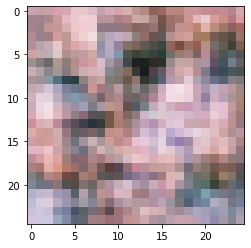

Step: 350
Generator adv: 0.148, rec: 0.072
Critic fake: 0.022 real: 0.873 grad: 2.192
Steps per second: 15.16


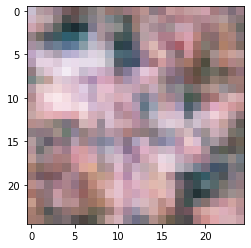

Step: 375
Generator adv: -0.075, rec: 0.072
Critic fake: -0.238 real: 0.902 grad: 2.674
Steps per second: 14.97


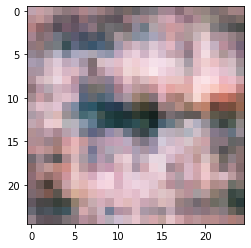

Step: 400
Generator adv: -0.162, rec: 0.071
Critic fake: 0.128 real: 0.853 grad: 3.188
Steps per second: 14.63


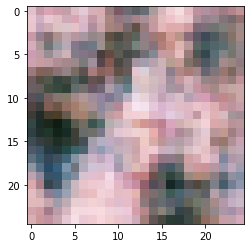

Step: 425
Generator adv: -0.241, rec: 0.070
Critic fake: -0.317 real: 1.014 grad: 5.649
Steps per second: 15.04


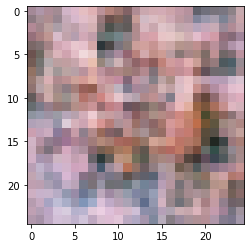

Step: 450
Generator adv: -0.086, rec: 0.070
Critic fake: 0.076 real: 0.988 grad: 2.802
Steps per second: 15.09


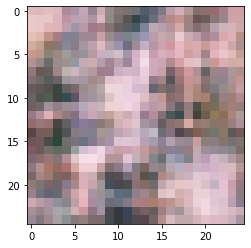

Step: 475
Generator adv: -0.030, rec: 0.072
Critic fake: 0.695 real: 1.211 grad: 1.914
Steps per second: 15.15


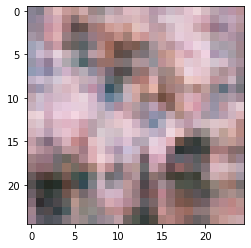

Step: 500
Generator adv: 0.249, rec: 0.072
Critic fake: 0.132 real: 0.983 grad: 4.616
Steps per second: 15.33


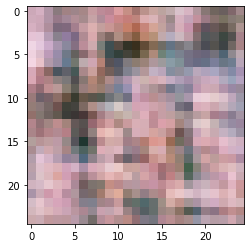

Step: 525
Generator adv: -0.062, rec: 0.071
Critic fake: -0.021 real: 0.944 grad: 1.415
Steps per second: 15.44


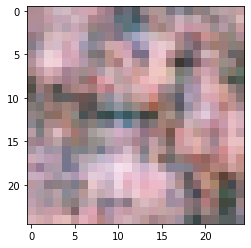

Step: 550
Generator adv: -0.036, rec: 0.069
Critic fake: -0.129 real: 1.007 grad: 3.393
Steps per second: 14.52


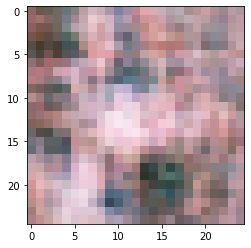

Step: 575
Generator adv: -0.251, rec: 0.068
Critic fake: -0.243 real: 1.055 grad: 3.401
Steps per second: 15.15


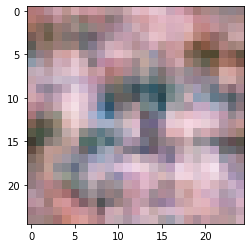

Step: 600
Generator adv: 0.110, rec: 0.068
Critic fake: -0.170 real: 1.060 grad: 3.257
Steps per second: 15.26


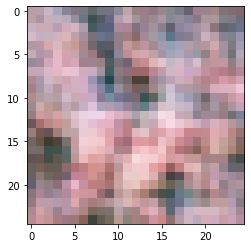

Step: 625
Generator adv: -0.182, rec: 0.068
Critic fake: 0.077 real: 1.002 grad: 2.665
Steps per second: 15.40


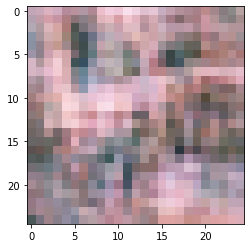

Step: 650
Generator adv: 0.206, rec: 0.068
Critic fake: -0.173 real: 1.131 grad: 2.517
Steps per second: 15.41


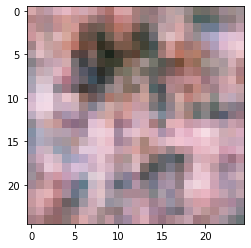

Step: 675
Generator adv: -0.051, rec: 0.069
Critic fake: 0.010 real: 1.072 grad: 4.009
Steps per second: 15.20


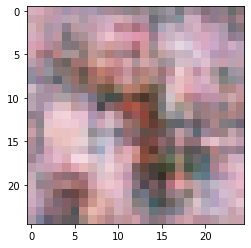

Step: 700
Generator adv: 0.231, rec: 0.069
Critic fake: 0.222 real: 1.150 grad: 3.607
Steps per second: 15.22


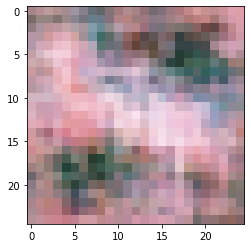

Step: 725
Generator adv: -0.458, rec: 0.068
Critic fake: -0.068 real: 1.093 grad: 3.250
Steps per second: 15.49


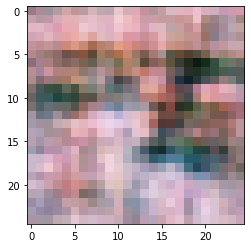

Step: 750
Generator adv: -0.029, rec: 0.068
Critic fake: -0.180 real: 1.113 grad: 2.905
Steps per second: 14.95


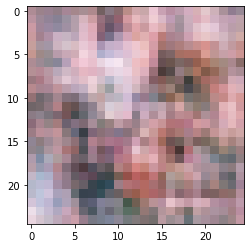

Step: 775
Generator adv: -0.230, rec: 0.068
Critic fake: -0.155 real: 1.173 grad: 4.287
Steps per second: 15.34


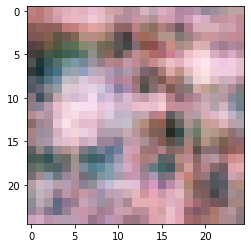

Step: 800
Generator adv: -0.096, rec: 0.068
Critic fake: -0.127 real: 1.124 grad: 3.876
Steps per second: 15.55


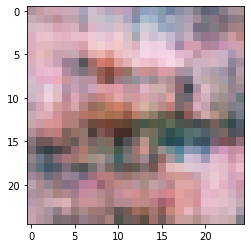

Step: 825
Generator adv: -0.275, rec: 0.068
Critic fake: 0.031 real: 1.098 grad: 2.451
Steps per second: 15.47


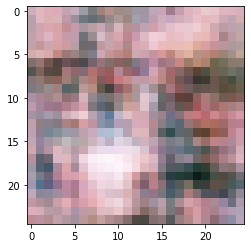

Step: 850
Generator adv: 0.048, rec: 0.068
Critic fake: -0.257 real: 1.096 grad: 4.096
Steps per second: 15.39


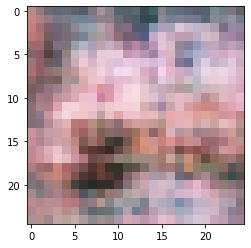

Step: 875
Generator adv: -0.348, rec: 0.068
Critic fake: 0.396 real: 1.155 grad: 3.235
Steps per second: 15.25


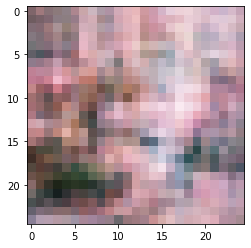

Step: 900
Generator adv: -0.365, rec: 0.068
Critic fake: 0.416 real: 1.198 grad: 3.364
Steps per second: 15.26


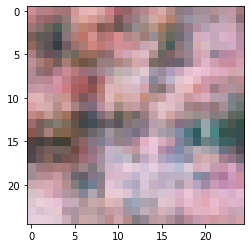

Step: 925
Generator adv: -0.053, rec: 0.069
Critic fake: 0.260 real: 1.239 grad: 4.661
Steps per second: 15.31


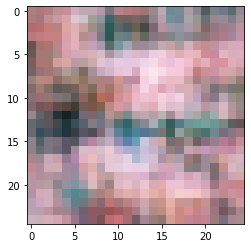

Step: 950
Generator adv: -0.185, rec: 0.068
Critic fake: 0.115 real: 1.277 grad: 4.438
Steps per second: 15.39


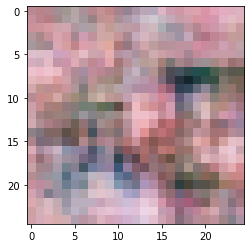

Step: 975
Generator adv: 0.118, rec: 0.068
Critic fake: -0.018 real: 1.205 grad: 4.337
Steps per second: 14.73


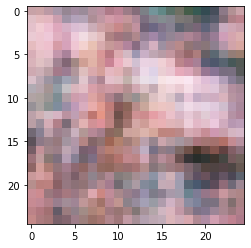

Step: 1000
Generator adv: -0.055, rec: 0.068
Critic fake: -0.003 real: 1.260 grad: 4.600
Steps per second: 15.43


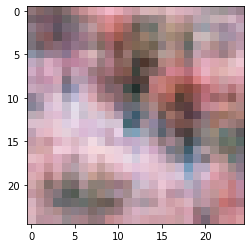

Step: 1025
Generator adv: -0.040, rec: 0.068
Critic fake: -0.056 real: 1.270 grad: 4.985
Steps per second: 15.65


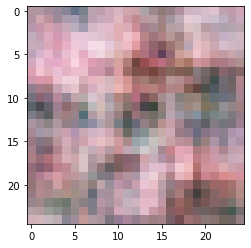

Step: 1050
Generator adv: 0.118, rec: 0.068
Critic fake: 0.258 real: 1.198 grad: 3.789
Steps per second: 15.08


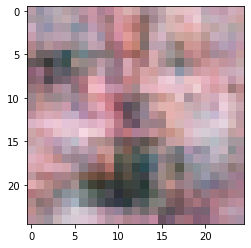

Step: 1075
Generator adv: -0.076, rec: 0.068
Critic fake: 0.033 real: 1.217 grad: 3.351
Steps per second: 15.33


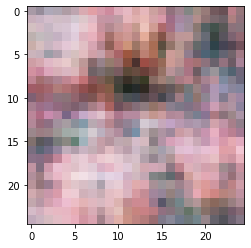

Step: 1100
Generator adv: -0.146, rec: 0.068
Critic fake: -0.015 real: 1.180 grad: 4.537
Steps per second: 15.50


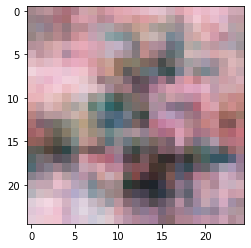

Step: 1125
Generator adv: 0.247, rec: 0.068
Critic fake: -0.017 real: 1.246 grad: 4.779
Steps per second: 15.42


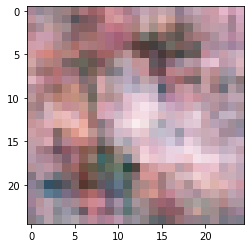

Step: 1150
Generator adv: -0.162, rec: 0.068
Critic fake: -0.138 real: 1.209 grad: 4.679
Steps per second: 15.53


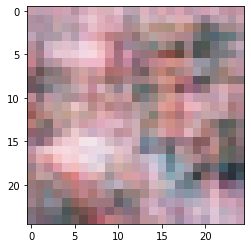

Step: 1175
Generator adv: 0.043, rec: 0.068
Critic fake: 0.294 real: 1.206 grad: 2.866
Steps per second: 15.58


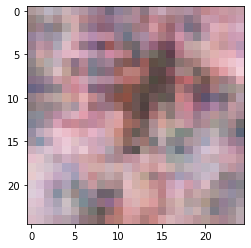

Step: 1200
Generator adv: 0.085, rec: 0.068
Critic fake: 0.003 real: 1.255 grad: 3.499
Steps per second: 15.40


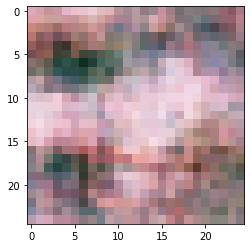

Step: 1225
Generator adv: -0.284, rec: 0.068
Critic fake: 0.045 real: 1.286 grad: 3.762
Steps per second: 15.24


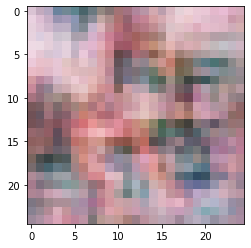

Step: 1250
Generator adv: -0.123, rec: 0.068
Critic fake: 0.031 real: 1.273 grad: 5.193
Steps per second: 14.77


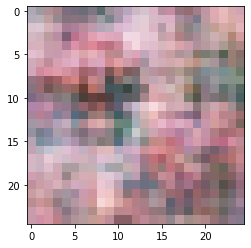

Step: 1275
Generator adv: 0.043, rec: 0.068
Critic fake: -0.245 real: 1.262 grad: 4.242
Steps per second: 15.29


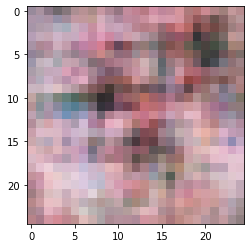

Step: 1300
Generator adv: -0.590, rec: 0.068
Critic fake: -0.209 real: 1.329 grad: 4.055
Steps per second: 15.19


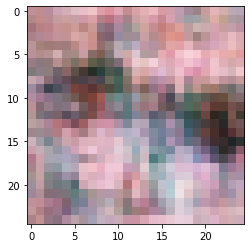

Step: 1325
Generator adv: -0.104, rec: 0.068
Critic fake: -0.087 real: 1.242 grad: 5.118
Steps per second: 15.17


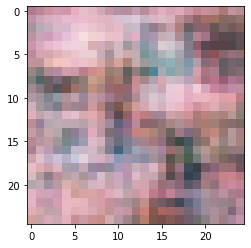

Step: 1350
Generator adv: -0.102, rec: 0.068
Critic fake: -0.270 real: 1.305 grad: 4.943
Steps per second: 15.07


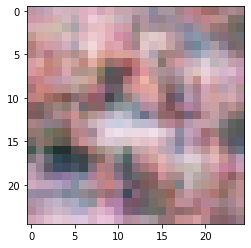

Step: 1375
Generator adv: 0.261, rec: 0.068
Critic fake: -0.371 real: 1.276 grad: 4.833
Steps per second: 15.21


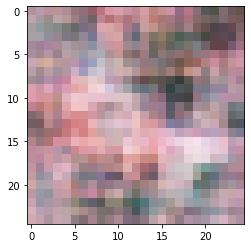

Step: 1400
Generator adv: -0.018, rec: 0.068
Critic fake: 0.265 real: 1.264 grad: 3.680
Steps per second: 15.30


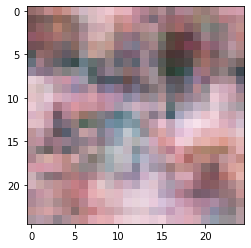

Step: 1425
Generator adv: -0.129, rec: 0.068
Critic fake: 0.365 real: 1.244 grad: 6.118
Steps per second: 14.40


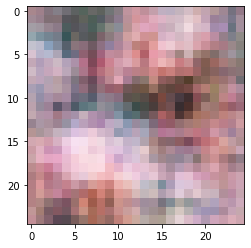

Step: 1450
Generator adv: -0.156, rec: 0.068
Critic fake: 0.130 real: 1.290 grad: 3.048
Steps per second: 15.44


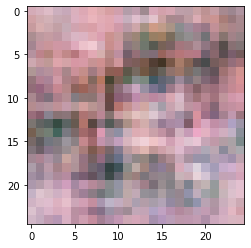

Step: 1475
Generator adv: -0.337, rec: 0.068
Critic fake: -0.166 real: 1.287 grad: 3.416
Steps per second: 15.10


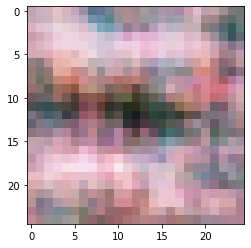

Step: 1500
Generator adv: 0.195, rec: 0.068
Critic fake: -0.031 real: 1.308 grad: 3.715
Steps per second: 15.11


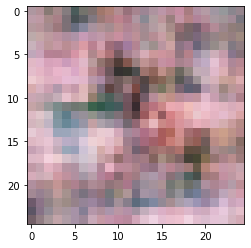

Step: 1525
Generator adv: 0.199, rec: 0.068
Critic fake: 0.025 real: 1.298 grad: 3.271
Steps per second: 15.46


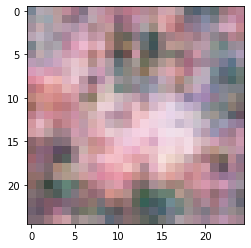

Step: 1550
Generator adv: 0.088, rec: 0.068
Critic fake: -0.072 real: 1.275 grad: 4.292
Steps per second: 15.42


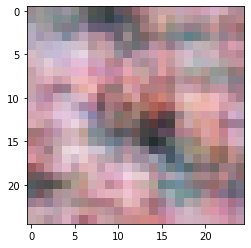

Step: 1575
Generator adv: 0.021, rec: 0.068
Critic fake: -0.139 real: 1.296 grad: 3.386
Steps per second: 15.11


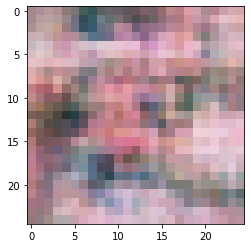

Step: 1600
Generator adv: -0.266, rec: 0.068
Critic fake: -0.171 real: 1.332 grad: 3.494
Steps per second: 15.51


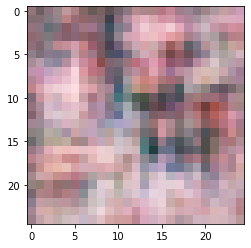

Step: 1625
Generator adv: 0.086, rec: 0.068
Critic fake: -0.207 real: 1.310 grad: 3.616
Steps per second: 15.35


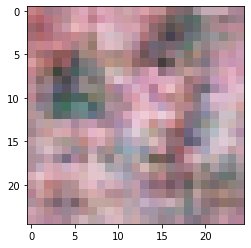

Step: 1650
Generator adv: -0.496, rec: 0.068
Critic fake: 0.195 real: 1.295 grad: 6.888
Steps per second: 15.36


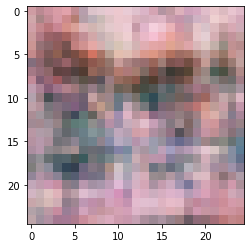

Step: 1675
Generator adv: -0.092, rec: 0.068
Critic fake: -0.104 real: 1.291 grad: 3.475
Steps per second: 15.32


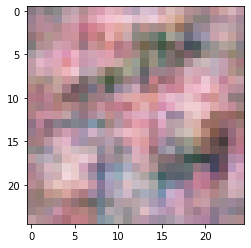

Step: 1700
Generator adv: -0.008, rec: 0.068
Critic fake: 0.163 real: 1.297 grad: 3.646
Steps per second: 14.81


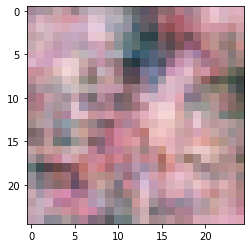

Step: 1725
Generator adv: 0.205, rec: 0.068
Critic fake: -0.162 real: 1.288 grad: 3.880
Steps per second: 15.28


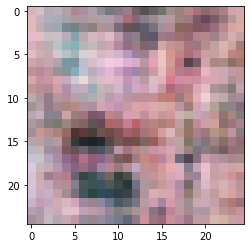

Step: 1750
Generator adv: -0.111, rec: 0.068
Critic fake: 0.053 real: 1.288 grad: 5.362
Steps per second: 15.45


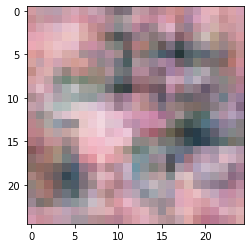

Step: 1775
Generator adv: 0.387, rec: 0.068
Critic fake: -0.068 real: 1.289 grad: 3.528
Steps per second: 15.29


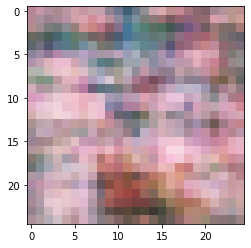

Step: 1800
Generator adv: 0.238, rec: 0.068
Critic fake: 0.282 real: 1.291 grad: 6.146
Steps per second: 15.44


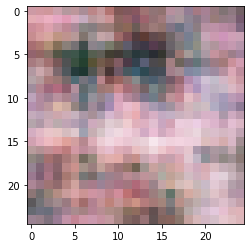

Step: 1825
Generator adv: -0.029, rec: 0.068
Critic fake: -0.131 real: 1.290 grad: 3.708
Steps per second: 15.47


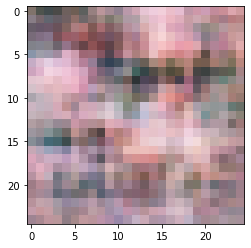

Step: 1850
Generator adv: 0.036, rec: 0.068
Critic fake: -0.186 real: 1.295 grad: 4.761
Steps per second: 14.75


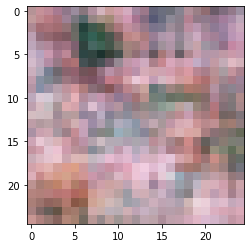

Step: 1875
Generator adv: 0.023, rec: 0.068
Critic fake: 0.071 real: 1.280 grad: 3.063
Steps per second: 15.29


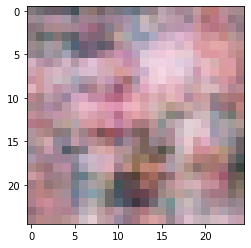

Step: 1900
Generator adv: 0.165, rec: 0.068
Critic fake: -0.051 real: 1.278 grad: 5.672
Steps per second: 15.14


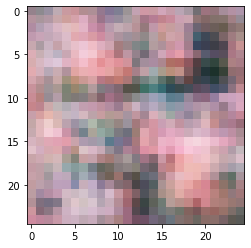

Step: 1925
Generator adv: -0.181, rec: 0.068
Critic fake: 0.010 real: 1.283 grad: 3.932
Steps per second: 15.24


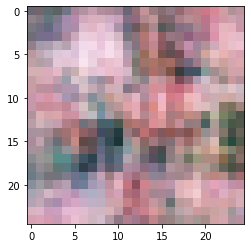

Step: 1950
Generator adv: 0.095, rec: 0.068
Critic fake: 0.153 real: 1.281 grad: 2.895
Steps per second: 15.33


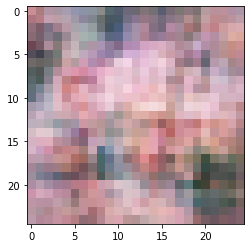

Step: 1975
Generator adv: 0.146, rec: 0.068
Critic fake: -0.117 real: 1.284 grad: 4.536
Steps per second: 15.43


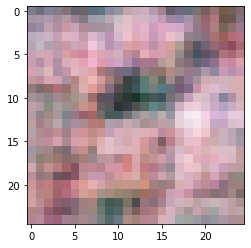

Reconstruction:


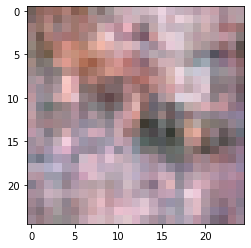

In [13]:

def img2net(img_uint):
  # convert [0, 255] uint8 (H, W, C) to [-1, 1] float32 (1, C, H, W)
  rescaled = (img_uint.astype('float32') / 127.5) - 1.0
  chw = np.transpose(rescaled, (2, 0, 1))
  return torch.from_numpy(np.expand_dims(chw, axis=0)).to(DEVICE)

def net2img(img_float):
  chw = np.squeeze(img_float.detach().cpu().numpy())
  hwc = np.transpose(chw, (1, 2, 0))
  return ((hwc + 1.0) * 127.5).astype('uint8')

def create_scale_pyramid(img, scaling_factor, num_scales):
  """ img: a 4D torch tensor """
  scaled_images = []
  scale_sizes = []
  shape = tuple(img.shape)[2:] # (N, C, H, W) -> (H, W)
  for i in range(num_scales):
    scale_sizes.append(shape)
    scaled_images.append(img)
    shape = tuple((np.array(shape, dtype='float64') * scaling_factor).astype('int64'))
    img = F.interpolate(img, size=shape, mode='bicubic')
  return scaled_images, scale_sizes

# seed stuff
np.random.seed(SEED)
torch.manual_seed(SEED)

# create the sizes
original_img = img2net(orig_img_uint)
original_img_scales, scale_sizes = create_scale_pyramid(original_img, 1/SCALING_FACTOR, NUM_SCALES)
original_img_scales, scale_sizes = original_img_scales[::-1], scale_sizes[::-1] # reverse since we start from coarsest

# create the constant noise used in reconstruction along with the MSE loss func.
z_rec_coarsest = sample_noise_like(original_img_scales[0], stdev=FIRST_SCALE_NOISE_STD, device=DEVICE)
z_rec = [z_rec_coarsest]

# constant zero input for the coarsest scale
generator_zero_input = torch.zeros_like(z_rec_coarsest)

kernel_count = INITIAL_KERNEL_COUNT
generator = None
generators = nn.ModuleList()
gen_losses, crit_losses = [], []
rmse = 1 # initial noise multiplier
for scale_index in range(NUM_SCALES):
  print('****************************\nScale {}'.format(scale_index))

  # get the original image at the necessary scale for reconstruction
  orig_img = original_img_scales[scale_index]

  if generator is not None:
    reconstruction = generator(generator_zero_input, z_rec)  
    # calculate the RMSE to use for scaling the input in the next step
    scaled_reconstruction = F.interpolate(reconstruction, size=scale_sizes[scale_index], mode='bicubic')
    rmse = F.mse_loss(scaled_reconstruction, orig_img).item()

  # create the noise sampler based on the RMSE
  # BUG: same noise_sampler is used for every scale, oof!
  noise_std = FIRST_SCALE_NOISE_STD if scale_index == 0 else rmse * NOISE_BASE_STD
  noise_sampler = lambda x: sample_noise_like(x, mean=0.0, stdev=noise_std, device=DEVICE)
  print('RMSE: {:.2f}'.format(rmse))

  ## initialize the generator
  # increase kernel count if necessary
  kernel_count_changed = False
  if scale_index != 0 and scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    kernel_count *= 2
    kernel_count_changed = True
  # create a generator for this specific scale
  scale_generator = SGNet(output_channels=3, kernel_count=kernel_count, final_activation=nn.Tanh(), conv_init=conv2d_initializer, bn_init=batch_norm_initializer).to(DEVICE)
  # if possible, initialize with weights from the lower layer
  if scale_index != 0 and not kernel_count_changed:
    prev_generator = generators[-1]
    prev_gen_weights = prev_generator.state_dict()
    scale_generator.load_state_dict(prev_gen_weights)
  # set train mode & add to generator list
  scale_generator.train()
  generators.append(scale_generator)
  # create a single generator view
  generator = MultiScaleSGNetView(generators, scale_sizes, noise_sampler)

  ## initialize the critic (discriminator)
  # the authors recommend initializing the discriminator using the weights of
  # the previous one, which means that we do not need to actually re-create 
  # unless the number of kernels is being changed
  if scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    critic = SGNet(output_channels=1, kernel_count=kernel_count, final_activation=None, conv_init=conv2d_initializer, bn_init=batch_norm_initializer).to(DEVICE) # patch critic

  # weight of gen0 to ensure it is not trained
  print('Norm sums:')
  for i, gen in enumerate(generators):
    wbs = get_weights_and_biases(gen)
    norm = torch.tensor([torch.norm(x) for x in wbs]).sum().item()
    print('Gen-{} norm: {:.2f}'.format(i, norm))
  print('Critic norm: {:.2f}'.format(torch.tensor([torch.norm(x) for x in get_weights_and_biases(critic)]).sum().item()))

  # re-create the optimizers and schedulers
  gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  gen_sched = torch.optim.lr_scheduler.StepLR(gen_optimizer, LR_DROP_STEP, LR_DROP_MULT)

  dis_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  dis_sched = torch.optim.lr_scheduler.StepLR(dis_optimizer, LR_DROP_STEP, LR_DROP_MULT)
    
  if scale_index != 0:
    z_rec.append(torch.zeros_like(orig_img))
  print(orig_img.shape)

  for step in range(NUM_ITERS):

    # real 1, fake 0

    for _ in range(DIS_STEP_PER_ITER):
      dis_optimizer.zero_grad()

      fake_imgc = generator(generator_zero_input)
      epsilon = np.random.uniform(0, 1)

      # adversarial loss
      # take a sample from the line between the real and generated images
      # for use in the gradient penalty (Impr. Training of WGANs)

      # another thing that is not very clear is the WGAN-GP loss in this context.
      # In the case of a scalar discr. output, what should be done is simply
      # norm the gradient (image-shaped) across the channel axis, and take 
      # the mean across all pixels.
      # In this case, the output of the critic (discr) is an image (PatchGAN).
      # If we take its mean to obtain a scalar and then apply the same approach
      # as the scalar output discr., it seems to supress the penalty twice 
      # (as if the mean was applied twice). Instead, taking the sum of the
      # output allows us to apply the mean only once, which we believe is the
      # proper normalization.

      grad_sample = epsilon * orig_img + (1 - epsilon) * fake_imgc
      f_grad_sample = critic(grad_sample).sum()
      grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True, retain_graph=True)

      # flat_grad = torch.flatten(flat_grad, start_dim=1) # (N, C, H, W) -> (N, C*H*W)
      # grad_loss = ((torch.norm(grad, p=2, dim=1) - 1)**2).mean() # mean over batch

      # for now though, use the same loss as the authors since it works
      grad_loss = ((torch.norm(grad, 2, dim=1) - 1)**2).mean() # mean over batch

      fake_loss = critic(fake_imgc).mean()
      real_loss = critic(orig_img).mean()
      dis_loss =  fake_loss - real_loss + GP_WEIGHT * grad_loss # TODO: are signs of fake and real loss correct? 
      dis_loss.backward()
      dis_optimizer.step()
      dis_sched.step()
      crit_losses.append(dis_loss.item())
    
    for _ in range(GEN_STEP_PER_ITER):
      gen_optimizer.zero_grad()

      # always provide zero input to the coarsest scale
      # the model handles noise sampling on its own
      fake_img = generator(generator_zero_input)

      # adversarial loss
      adv_loss = -critic(fake_img).mean()

      # reconstruction loss
      rec_img = generator(generator_zero_input, z_rec)
      # the representation space of the images is not clear in the paper.
      # since the reconstruction loss seemed very low to us in the [-1, 1]
      # range, we decided to calculate it in the [0, 255] range instead
      # EDIT: after checking out their own code, it seems that there is
      # no multiplier. however, the reconstruction loss remains too small?
      rec_loss = F.mse_loss(orig_img, rec_img)

      gen_loss = adv_loss + REC_ALPHA * rec_loss
      gen_loss.backward()
      gen_optimizer.step()
      gen_sched.step()
      gen_losses.append(gen_loss.item())

    if step % PRINT_EVERY == 0:
      print('Step: {}'.format(step))
      print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.item(), rec_loss.item()))
      print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.item(), real_loss.item(), grad_loss.item()))
      if step != 0:
        elapsed = time() - last_print
        print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
      plt.imshow(net2img(fake_img))
      plt.show()
      last_print = time()

  print('Reconstruction:')
  plt.imshow(net2img(generator(generator_zero_input, z_rec)))
  plt.show()


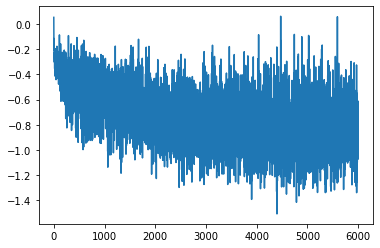

In [14]:
plt.plot(crit_losses)
plt.show()

In [15]:
!nvidia-smi

Mon May 18 16:59:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    719MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
print(SGNet(output_channels=1, kernel_count=kernel_count, final_activation=nn.Identity()).to(DEVICE)(torch.ones(1, 3, 5, 5).cuda()))

tensor([[[[ 0.3255,  0.1632,  1.0725,  0.8181,  0.0989],
          [ 0.6618,  0.0165,  0.5550,  0.5524,  0.1002],
          [-0.0705, -0.8659, -0.0857,  0.4745,  0.4221],
          [ 0.4590, -0.0800,  0.1563,  0.5252,  0.3780],
          [ 0.5193,  0.1316,  0.2902,  0.5200,  0.5651]]]], device='cuda:0',
       grad_fn=<AddBackward0>)
